In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import numpy as np


/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12321, receiver_port=12322)
model = dynapse.model

[0]:  Bus 3 Device 22 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 121 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 118 Dynapse1DevKit serial_number 00000000
[3]:  Bus 1 Device 120 Dynapse1DevKit serial_number 00000011
[4]:  Bus 1 Device 84 Dynapse1DevKit serial_number 00000007
[5]:  Bus 1 Device 34 Dynapse1DevKit serial_number 00000020
[6]:  Bus 1 Device 87 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12321
Receiver port: tcp://0.0.0.0:12322
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [34]:
schip = score = 0
chip = core = 0

num_neurons = 15

nids1 = np.arange(num_neurons+1, 2*num_neurons+1)
nids2 = np.arange(2*num_neurons+1, 3*num_neurons+1)

all_nids = np.concatenate((nids1, nids2), axis = 0)

# init a network generator
net = network.DynapseNetworkGenerator()
dynapse.monitor_neurons(chip, core, all_nids)

# remove the existing network in netgen
net.clear_network()

# spikegens = net.get_spikegens(schip, score, snids)
neurons_E1 = net.get_neurons(chip, core, nids1)
neurons_E2 = net.get_neurons(chip, core, nids2)

net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA, 1, 1)
net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA, 1, 1)
net.add_connections_all_to_all(neurons_E1, neurons_E2, network.SYNAPSE_GABA_B, 2, 1)
net.add_connections_all_to_all(neurons_E2, neurons_E1, network.SYNAPSE_GABA_B, 2, 1)

# make a dynapse1config using the network
model.apply_configuration(net.get_config())


Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


In [35]:
# set params
parameters.set_all_default_params(model)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (4,255), chip, core)
# parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,20), chip, core)
parameters.set_param(model, parameters.ADAPTATION_GAIN, (7,80), chip, core)
parameters.set_param(model, parameters.ADAPTATION_TIME_CONSTANT, (1,80), chip, core)
parameters.set_param(model, parameters.ADAPTATION_WEIGHT, (7,80), chip, core)
# parameters.set_param(model, parameters.ADAPTATION_SOMETHING (3,80), chip, core)


752941184.0

In [38]:
duration = 30

# poisson_gen.start()
dynapse.start_graph()
dynapse.run_simulation(1)
spikes = dynapse.run_simulation(duration)
dynapse.stop_graph()
# poisson_gen.stop()


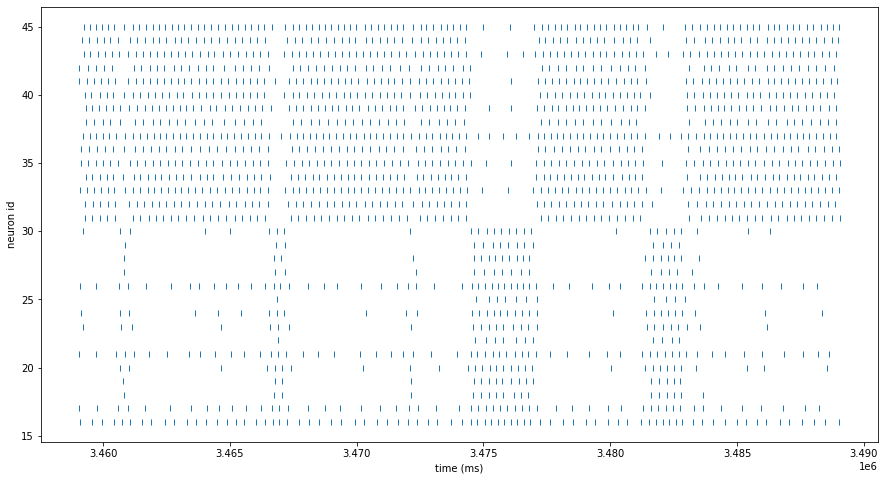

In [44]:
plt.figure(figsize=[15,8])
plt.plot([spike.timestamp/1000 for spike in spikes], [spike.id for spike in spikes],'|')

plt.xlabel('time (ms)')
plt.ylabel('neuron id')

plt.show()

In [21]:
import time
import cv2
from IPython.display import clear_output

(12,)
[31 32 34 35 37 38 39 40 41 42 44 45]
[1 1 1 1 1 1 1 1 1 1 1 1]


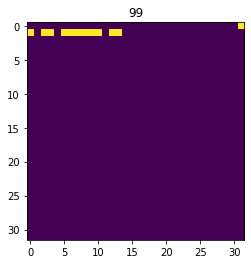

In [33]:
# poisson_gen.start()
dynapse.start_graph()

for i in range(100):
    spikes = dynapse.sink_node.get_buf()
    spike_ids = np.array([1024*spike.chip_id+256*spike.core_id+spike.neuron_id for spike in spikes])
    print(np.shape(spike_ids))
    spiking_neurons = np.unique(spike_ids)
    print(spiking_neurons)
    rates = np.array([np.count_nonzero(spike_ids == neuron_index) for neuron_index in spiking_neurons])
    print(rates)
    img = np.zeros(1024)
    if len(spikes) > 0:
        img[spiking_neurons] = rates
    plt.imshow(np.reshape(img,(32,32)))
    plt.title(str(i))
    plt.show()
    clear_output(wait=True)

dynapse.stop_graph()
# poisson_gen.stop()